In [3]:
import pandas as pd, numpy as np, os, matplotlib as mpl, seaborn, matplotlib.pyplot as plt, re

from matplotlib.patches import Patch
from matplotlib import ticker
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

from sklearn import datasets, manifold, metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import auc, fbeta_score

from admet_ai import ADMETModel
from chemprop.data.utils import get_data, split_data

import shap, umap, _pickle as pickle
from scipy import stats

import argparse
import datetime


In [28]:
path_to_repo = '/Users/souhridm/Downloads/ADMET_AI_data'

In [29]:
did = datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
# print(did)

In [42]:
xxx = '''
HIA_Hou	Human Intestinal Absorption
Bioavailability_Ma	Oral Bioavailability
Solubility_AqSolDB	Aqueous Solubility
Lipophilicity_AstraZeneca	Lipophilicity
HydrationFreeEnergy_FreeSolv	Hydration Free Energy
Caco2_Wang	Cell Effective Permeability
PAMPA_NCATS	PAMPA Permeability
Pgp_Broccatelli	P-glycoprotein Inhibition
BBB_Martins	Blood-Brain Barrier Penetration
PPBR_AZ	Plasma Protein Binding Rate
VDss_Lombardo	Volume of Distribution at Steady State
Half_Life_Obach	Half Life
Clearance_Hepatocyte_AZ	Drug Clearance (Hepatocyte)
Clearance_Microsome_AZ	Drug Clearance (Microsome)
CYP1A2_Veith	CYP1A2 Inhibition
CYP2C19_Veith	CYP2C19 Inhibition
CYP2C9_Substrate_CarbonMangels	CYP2C9 Substrate
CYP2C9_Veith	CYP2C9 Inhibition
CYP2D6_Substrate_CarbonMangels	CYP2D6 Substrate
CYP2D6_Veith	CYP2D6 Inhibition
CYP3A4_Substrate_CarbonMangels	CYP3A4 Substrate
CYP3A4_Veith	CYP3A4 Inhibition
hERG	hERG Blocking
ClinTox	Clinical Toxicity
AMES	Mutagenicity
DILI	Drug Induced Liver Injury
Carcinogens_Lagunin	Carcinogenicity
LD50_Zhu	Acute Toxicity LD50
Skin_Reaction	Skin Reaction
NR-AR	Androgen Receptor (Full Length)
NR-AR-LBD	Androgen Receptor (Ligand Binding Domain)
NR-AhR	Aryl Hydrocarbon Receptor
NR-Aromatase	Aromatase
NR-ER	Estrogen Receptor (Full Length)
NR-ER-LBD	Estrogen Receptor (Ligand Binding Domain)
NR-PPAR-gamma	Peroxisome Proliferator-Activated Receptor Gamma
SR-ARE	Nrf2-Antioxidant Responsive Element
SR-ATAD5	ATPase Family AAA Domain-Containing Protein 5 (ATAD5)
SR-HSE	Heat Shock Factor Response Element
SR-MMP	Mitochondrial Membrane Potential
SR-p53	Tumor Protein p53
'''.split('\n')[1:-1]
feat_name_dict = {}
for l in xxx:
    y = l.split('\t')
    feat_name_dict[y[0]] = y[1].replace('/', '\n')

admet_ai_feats = [
       'AMES', 'BBB_Martins', 'Bioavailability_Ma', 'CYP1A2_Veith',
       'CYP2C19_Veith', 'CYP2C9_Substrate_CarbonMangels', 'CYP2C9_Veith',
       'CYP2D6_Substrate_CarbonMangels', 'CYP2D6_Veith',
       'CYP3A4_Substrate_CarbonMangels', 'CYP3A4_Veith', 'Carcinogens_Lagunin',
       'ClinTox', 'DILI', 'HIA_Hou', 'NR-AR-LBD', 'NR-AR', 'NR-AhR',
       'NR-Aromatase', 'NR-ER-LBD', 'NR-ER', 'NR-PPAR-gamma', 'PAMPA_NCATS',
       'Pgp_Broccatelli', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53',
       'Skin_Reaction', 'hERG', 'Caco2_Wang', 'Clearance_Hepatocyte_AZ',
       'Clearance_Microsome_AZ', 'Half_Life_Obach',
       'HydrationFreeEnergy_FreeSolv', 'LD50_Zhu', 'Lipophilicity_AstraZeneca',
       'PPBR_AZ', 'Solubility_AqSolDB', 'VDss_Lombardo'
             ]

In [140]:
xgbs = []
for r, d, f in os.walk(os.path.join(path_to_repo, 'models', 'ensemble')):
    for fname in f:
        x = pickle.load(open(os.path.join(r, fname), 'rb'))
        xgbs.append(x)

[GradientBoostingClassifier(max_depth=12, n_estimators=500, random_state=0),
 GradientBoostingClassifier(max_depth=12, n_estimators=500, random_state=0),
 GradientBoostingClassifier(max_depth=12, n_estimators=500, random_state=0),
 GradientBoostingClassifier(max_depth=12, n_estimators=500, random_state=0),
 GradientBoostingClassifier(max_depth=12, n_estimators=500, random_state=0),
 GradientBoostingClassifier(max_depth=12, n_estimators=500, random_state=0),
 GradientBoostingClassifier(max_depth=12, n_estimators=500, random_state=0),
 GradientBoostingClassifier(max_depth=12, n_estimators=500, random_state=0),
 GradientBoostingClassifier(max_depth=12, n_estimators=500, random_state=0),
 GradientBoostingClassifier(max_depth=12, n_estimators=500, random_state=0)]

In [122]:
parser = argparse.ArgumentParser()
parser.add_argument('-s', '--smiles', type=str, dest='smiles', required=False,
                    help="individual SMILES string, to predict DICT concern - based on ADMET-AI")
parser.add_argument('-l', '--list', type=str, dest='list',  required=False,
                    help=".txt file contining list of SMILES strings, to predict DICT concern - based on ADMET-AI")
parser.add_argument('-n', '--name', type=str, dest='name',  default=did,
                    help="Run ID or name")
parser.add_argument('-o', '--out_path', type=str, dest='out_path',  default=os.getcwd(),
                    help="Output folder or directory")


args = parser.parse_args()
if args.smiles:
    smiles = [args.smiles]
elif args.list:
    smiles = open(args.list).read().split('\n')[:-1]
jname = args.name
out_path = args.out_path
print(args)


usage: ipykernel_launcher.py [-h] [-s SMILES] [-l LIST] [-n NAME]
                             [-o OUT_PATH]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/souhridm/Library/Jupyter/runtime/kernel-90efe4fa-d3d9-4359-ae09-f3aea35467c1.json


SystemExit: 2

/Users/souhridm/anaconda3/envs/renv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3450: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [130]:
smiles = ['C1=CC(=CC=C1C2=COC3=CC(=CC(=C3C2=O)O)O)O', 
          'CN(CCC1=CC=C(C=C1)NS(=O)(=O)C)CCOC2=CC=C(C=C2)NS(=O)(=O)C',
         'CO[C@H]1CN(CC[C@H]1NC(=O)C2=CC(=C(C=C2OC)N)Cl)CCCOC3=CC=C(C=C3)F',
         'CC1=C(C=C(C=C1)C2C(C(C(C(O2)CO)O)O)O)CC3=CC=C(S3)C4=CC=C(C=C4)F']
out_path = os.getcwd()
jname = did

In [147]:
model = ADMETModel()
preds = model.predict(smiles=smiles)[admet_ai_feats].rename(columns=feat_name_dict)
probs = []
for x in xgbs:
    p = x.predict_proba(preds)[:,1]
    probs.append(p)
    
dictrank_probs = np.mean(np.asarray(probs), axis=0)
preds['pred. DICT concern'] = dictrank_probs
sel_feats = [
            "CYP2D6 Substrate",
            "CYP2D6 Inhibition",
            "Nrf2-Antioxidant Responsive Element",
            "Heat Shock Factor Response Element",
            "Aromatase",
            ]
preds = preds[['pred. DICT concern'] + sel_feats + [x for x in preds.columns if x not in sel_feats and x != 'pred. DICT concern']]
preds.to_csv(os.path.join(out_path, '{n}_ADMET-AI_DICTrank_preds.csv'.format(n=jname)))
print(preds)

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.b

RDKit fingerprints:   0%|                                 | 0/4 [00:00<?, ?it/s]/Users/souhridm/anaconda3/envs/renv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:7544: RuntimeWarning: overflow encountered in _ncf_cdf
  return _boost._ncf_cdf(x, dfn, dfd, nc)
individual models:   0%|                                  | 0/5 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

                                                                                

  0%|                                                     | 0/1 [00:00<?, ?it/s]

                                                                                

  0%|                                                     | 0/1 [00:00<?, ?it/s]

                                                                                

  0%|                                                     | 0/1 [00:00<?, ?it/s]

                                                                    

                                                    pred. DICT concern  \
C1=CC(=CC=C1C2=COC3=CC(=CC(=C3C2=O)O)O)O                      0.700666   
CN(CCC1=CC=C(C=C1)NS(=O)(=O)C)CCOC2=CC=C(C=C2)N...            1.000000   
CO[C@H]1CN(CC[C@H]1NC(=O)C2=CC(=C(C=C2OC)N)Cl)C...            0.802004   
CC1=C(C=C(C=C1)C2C(C(C(C(O2)CO)O)O)O)CC3=CC=C(S...            0.100000   

                                                    CYP2D6 Substrate  \
C1=CC(=CC=C1C2=COC3=CC(=CC(=C3C2=O)O)O)O                    0.100115   
CN(CCC1=CC=C(C=C1)NS(=O)(=O)C)CCOC2=CC=C(C=C2)N...          0.397953   
CO[C@H]1CN(CC[C@H]1NC(=O)C2=CC(=C(C=C2OC)N)Cl)C...          0.588081   
CC1=C(C=C(C=C1)C2C(C(C(C(O2)CO)O)O)O)CC3=CC=C(S...          0.122097   

                                                    CYP2D6 Inhibition  \
C1=CC(=CC=C1C2=COC3=CC(=CC(=C3C2=O)O)O)O                     0.387166   
CN(CCC1=CC=C(C=C1)NS(=O)(=O)C)CCOC2=CC=C(C=C2)N...           0.525021   
CO[C@H]1CN(CC[C@H]1NC(=O)C2=CC(=C(C=C2OC)N)Cl)C..

In [148]:
# Define parameters for radial plots

property_ids = [
    "CYP2D6 Substrate",
    "CYP2D6 Inhibition",
    "Nrf2-Antioxidant Responsive Element",
    "Heat Shock Factor Response Element",
    "Aromatase",
]
property_ids = [f"{property_id}" for property_id in property_ids]
property_names = [
    "CYP2D6\nSubstrate",
    "CYP2D6\nInhibition",
    "Nrf2-Antioxidant\nResponsive\nElement",
    "Heat Shock Factor\nResponse Element",
    "Aromatase",
]

dictrank_colors2 = {
                    'none': '#99d594',
                    'most': '#df65b0', 
                    'withdrawn': 'red'
                    }

In [149]:
## Function to plot radial plot

def plot_radial_list_drugs(df, drugs, colors, tox_label):
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    for j, d in enumerate(drugs):
        d = str(d)
        plt.plot([], [], label=d[0].upper() + d[1:], color=colors[j], linewidth=4,
                )
        dfi = df[df['name'] == d]
        values = []
        for f in property_ids:
            values.append(dfi[f].values[0])

    # Calculate the angles of the plot (angles start at pi / 2 and go counter-clockwise)
        angles = (
            (np.linspace(0, 2 * np.pi, len(values), endpoint=False) + np.pi / 2)
            % (2 * np.pi)
        ).tolist()

        # Complete the loop
        values += values[:1]
        angles += angles[:1]

        ax.plot(angles, values, color=colors[j], linewidth=4, 
               )

        # Set y limits
        ax.set_ylim(0, 1)

        # Labels for radial lines
        yticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
        yticklabels = [str(ytick) for ytick in yticks]
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels, fontsize=12)
        ax.set_rlabel_position(335)

        # Labels for categories
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(property_names, fontsize=18)

        # Adjust xticklabels so they don't overlap the plot
        for i, (label, property_name) in enumerate(
            zip(ax.get_xticklabels(), property_names)
        ):
            if i in [1, 4]:
                label.set_verticalalignment("bottom")
            elif i in [2, 3]:
                label.set_verticalalignment("top")

    # Make the plot square
    ax.set_aspect("equal", "box")
    plt.legend(bbox_to_anchor=(1.2, 1.1), fontsize=14)
    ax.set_title('{l}'.format(l=tox_label), fontsize=22, weight='bold')
    plt.tight_layout()

    return fig


1 - CC1=C(C=C(C=C1)C2C(C(C(C(O2)CO)O)O)O)CC3=CC=C(S3)C4=CC=C(C=C4)F - 0.1
2 - C1=CC(=CC=C1C2=COC3=CC(=CC(=C3C2=O)O)O)O - 0.701
3 - CO[C@H]1CN(CC[C@H]1NC(=O)C2=CC(=C(C=C2OC)N)Cl)CCCOC3=CC=C(C=C3)F - 0.802
4 - CN(CCC1=CC=C(C=C1)NS(=O)(=O)C)CCOC2=CC=C(C=C2)NS(=O)(=O)C - 1


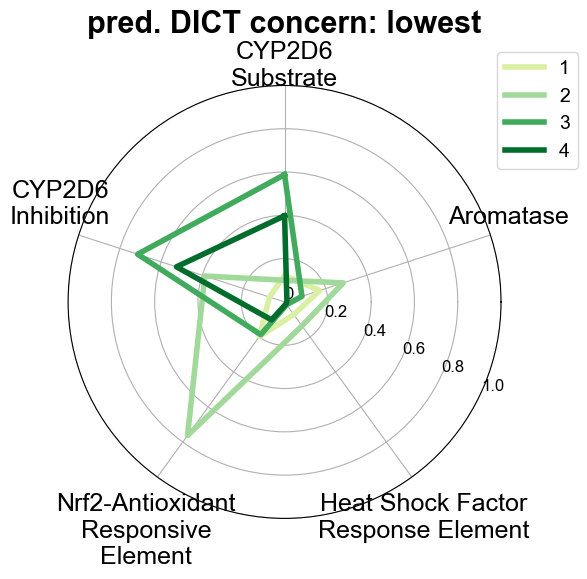

In [150]:
# Plot radial plot for 5 drugs with least DICT concern

n = int(np.minimum(len(preds.index), 5))
preds_low = preds.sort_values(by='pred. DICT concern', ascending=True)[:n]
preds_low['name'] = [str(x + 1) for x in np.arange(0, n)]

no_DICT_concern_drugs_list = [str(x + 1) for x in np.arange(0, n)]
no_DICT_concern_drugs_colors = ['#d9f0a3', '#a1d99b', '#41ab5d', '#006d2c', '#00441b']

fig = plot_radial_list_drugs(
                             df=preds_low, 
                             drugs=no_DICT_concern_drugs_list,
                             colors=no_DICT_concern_drugs_colors, 
                             tox_label='pred. DICT concern: lowest'
                            )

fig.savefig(os.path.join(out_path, 'least_DICT_concern_drugs_radial_plot.pdf'))

for i, s in enumerate(preds_low.index):
    print('{i} - {s} - {v}'.format(i=i+1, s=s, v='%0.3g'%preds_low['pred. DICT concern'][s]))


1 - CN(CCC1=CC=C(C=C1)NS(=O)(=O)C)CCOC2=CC=C(C=C2)NS(=O)(=O)C - 1
2 - CO[C@H]1CN(CC[C@H]1NC(=O)C2=CC(=C(C=C2OC)N)Cl)CCCOC3=CC=C(C=C3)F - 0.802
3 - C1=CC(=CC=C1C2=COC3=CC(=CC(=C3C2=O)O)O)O - 0.701
4 - CC1=C(C=C(C=C1)C2C(C(C(C(O2)CO)O)O)O)CC3=CC=C(S3)C4=CC=C(C=C4)F - 0.1


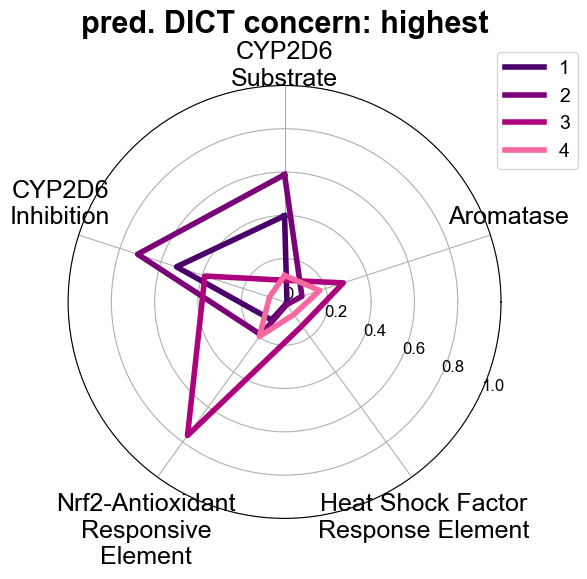

In [153]:
# Plot radial plot for 5 drugs with most DICT concern

n = int(np.minimum(len(preds.index), 5))
preds_high = preds.sort_values(by='pred. DICT concern', ascending=False)[:n]
preds_high['name'] = [str(x + 1) for x in np.arange(0, n)]

most_DICT_concern_drugs_list = [str(x + 1) for x in np.arange(0, n)]
most_DICT_concern_drugs_colors = ['#49006a', '#7a0177', '#ae017e', '#f768a1', '#c994c7']

fig = plot_radial_list_drugs(
                             df=preds_high, 
                             drugs=most_DICT_concern_drugs_list,
                             colors=most_DICT_concern_drugs_colors, 
                             tox_label='pred. DICT concern: highest'
                            )

fig.savefig(os.path.join(out_path, 'most_DICT_concern_drugs_radial_plot.pdf'))

for i, s in enumerate(preds_high.index):
    print('{i} - {s} - {v}'.format(i=i+1, s=s, v='%0.3g'%preds_high['pred. DICT concern'][s]))
